# Практика: линейная регрессия и метод наименьших квадратов
# Практика: полиномиальная регрессия и регуляризация
Александр Журавлев DST-120

***

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: в этом году он открывает 100 новых скважин по добыче газа. Однако в целях оптимизации расходов и для потенциального повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы потенциально сильнейшим образом влияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста по построению моделей машинного обучения.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать здесь.

Признаки:

**Well** — идентификатор скважины;    
**Por** — пористость скважины (%);    
**Perm** — проницаемость скважины;    
**AI** — акустический импеданс (кг/м2*10ˆ6);    
**Brittle** — коэффициент хрупкости скважины (%);    
**TOC** — общий органический углерод (%);     
**VR** — коэффициент отражения витринита (%);     
**Prod** — добыча газа в сутки (млн. кубических футов).    

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

***

In [1]:
# импортируем необходимые библиотеки
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn import metrics # метрики
from sklearn.model_selection import cross_validate # для кросс-валидации
from sklearn.linear_model import LinearRegression, Lasso, Ridge # линейные модели
from sklearn.preprocessing import PolynomialFeatures # для полиномиальных признаков
from sklearn.preprocessing import StandardScaler # для стандартизации

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

In [2]:
# загружаем и выводим данные
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


Для начала в качестве модели будем использовать простую линейную регрессию.

***

### Задание 5.1

Постройте корреляционную матрицу факторов, включив в неё целевой признак. Ответьте на следующие вопросы:

1. Выберите топ-3 факторов, наиболее коррелированных с целевой переменной:

In [3]:
# строим корреляционную матрицу
data.corr()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


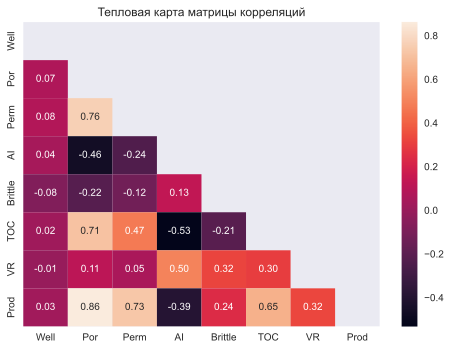

In [4]:
# строим тепловую карту матрицы корреляций
sns.heatmap(data.corr(), annot=True, fmt='.2f', mask = np.triu(data.corr())).set(
    title = "Тепловая карта матрицы корреляций"
);

Por        0.861910
Perm       0.727426
TOC        0.654445
AI         0.390835
VR         0.323182
Brittle    0.237155
Well       0.026817
Name: Prod, dtype: float64


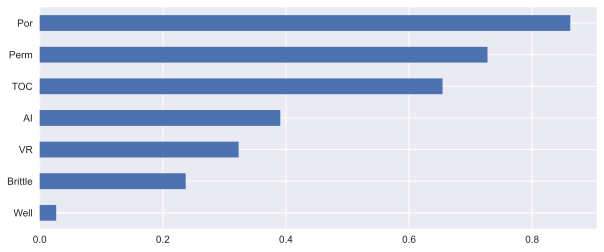

In [5]:
# выведем топ коррелирующих с таргетом факторов
print(data.corr()["Prod"].apply(lambda x: abs(x)).sort_values(ascending=False)[1:])
data.corr()["Prod"].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh(figsize=(10, 4));

2. Вычислите ранг полученной матрицы корреляций:

In [6]:
print(f'Ранг матрицы корреляций равен {np.linalg.matrix_rank(data.corr())}')

Ранг матрицы корреляций равен 8


3. Вычислите определитель матрицы корреляций. Ответ округлите до четвёртого знака после точки-разделителя.

In [7]:
print(f'Определитель матрицы коррелиций: {round(np.linalg.det(data.corr()),4)}')

Определитель матрицы коррелиций: 0.0007


***

### Задание 5.2

Создайте матрицу наблюдений. Обозначьте её за **X**, а вектор правильных ответов — за **y**.

1. Постройте модель линейной регрессии по методу наименьших квадратов. Для этого используйте **матричную формулу NumPy**. В качестве ответа укажите полученные оценки коэффициентов модели. Ответ округлите до целого числа.

In [8]:
# создаем матрицу наблюдений X и вектор правильных ответов y
X = np.array(data.drop(['Prod'], axis=1))
y = np.array(data[['Prod']])

# строим модель линейной регрессии
# создаём вектор из единиц
ones = np.ones(X.shape[0])
# добавляем вектор к таблице первым столбцом
X = np.column_stack([ones, X])
# вычисляем обратную матрицу Q
Q = np.linalg.inv(X.T @ X)
# вычисляем вектор коэффициентов
w = Q @ X.T @ y

In [9]:
# выводим вычисленные значения коэффициентов в виде вектора
print('Vector w:\n {}'.format(np.around(w)))

Vector w:
 [[-1232.]
 [    0.]
 [  230.]
 [  116.]
 [ -365.]
 [   25.]
 [  -78.]
 [  785.]]


In [10]:
# составляем таблицу из признаков и их коэффициентов округленных до целого
w_df = pd.DataFrame({
    'Features': data.drop('Prod', axis=1).columns, 
    'Coefficients': np.round(w[1:,0])
})

# составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({
    'Features': ['INTERCEPT'], 
    'Coefficients': round(w[0,0])
})

# объединяем таблицы
coef_df = pd.concat([intercept_df, w_df], ignore_index=True)

display(coef_df)

,Features,Coefficients
0,INTERCEPT,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


***

### Задание 5.3

Далее потренируемся строить предсказание для наблюдений целевой переменной.

1. Постройте прогноз выработки газа для скважины с параметрами, указанными ниже. Чему равна абсолютная ошибка построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день). Ответ округлите до целого числа.

In [11]:
# задаём параметры
well_param = 106
por_param = 15.32
perm_param = 3.71
ai_param = 3.29
brittle_param = 55.99 
toc_param = 1.35
vr_param = 2.42

# зададим реальное количество добычи газа в сутки
prod_real = 4748.315024

# делаем предсказание
prod_predict = (
    w[0,0] + 
    w[1,0]*well_param + 
    w[2,0]*por_param + 
    w[3,0]*perm_param + 
    w[4,0]*ai_param + 
    w[5,0]*brittle_param + 
    w[6,0]*toc_param + 
    w[7,0]*vr_param
)

print('Предсказанное значение: {}'.format(prod_predict))
print('Реальное значение: {}'.format(prod_real))
print('Абсолютная ошибка: {}'.format(prod_real - prod_predict))

Предсказанное значение: 4723.064053707253
Реальное значение: 4748.315024
Абсолютная ошибка: 25.250970292747297


2. Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Чему равно значение метрики **MAPE** вашей модели? Ответ приведите в процентах (не указывайте знак процента), округлив его до первого знака после точки-разделителя.

In [12]:
# задаем столбец с предсказанным таргетом
data['Prod_predict'] = 0

# перебираем строки датасета
for index, row in data.iterrows():
    # задаём параметры
    well_param = row['Well']
    por_param = row['Por']
    perm_param = row['Perm']
    ai_param = row['AI']
    brittle_param = row['Brittle'] 
    toc_param = row['TOC']
    vr_param = row['VR']

    # делаем предсказание
    data.loc[index, 'Prod_predict'] = (
        w[0,0] + 
        w[1,0]*well_param + 
        w[2,0]*por_param + 
        w[3,0]*perm_param + 
        w[4,0]*ai_param + 
        w[5,0]*brittle_param + 
        w[6,0]*toc_param + 
        w[7,0]*vr_param
    )    

# задаем реальные значения таргета
y_real = data['Prod']
# задаем предсказанные значения таргета
y_predict = data['Prod_predict']

#Рассчитываем MAPE
print('MAPE score: {:.1f} %'.format(metrics.mean_absolute_percentage_error(y_real, y_predict) * 100))

MAPE score: 3.6 %


***

Задание 5.4

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.


1. Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целью прямая, а модель говорит обратное.

In [13]:
display(coef_df)
display(data.corr()["Prod"])

,Features,Coefficients
0,INTERCEPT,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


Well            0.026817
Por             0.861910
Perm            0.727426
AI             -0.390835
Brittle         0.237155
TOC             0.654445
VR              0.323182
Prod            1.000000
Prod_predict    0.979720
Name: Prod, dtype: float64

Действительно, есть такой коэффициент **w_TOC**. Согласно построенной модели, зависимость между процентом органического углерода и производительностью скважины обратная. Однако, согласно положительному коэффициенту корреляции между этим факторым и целевым признаком, равным 0.65 (а также согласно реальным фактам из сферы добычи газа), зависимость должна быть прямой.     
Чтобы убедиться в этом, можно построить диаграмму рассеяния, отражающую зависимость между **TOC** и **Prod**:

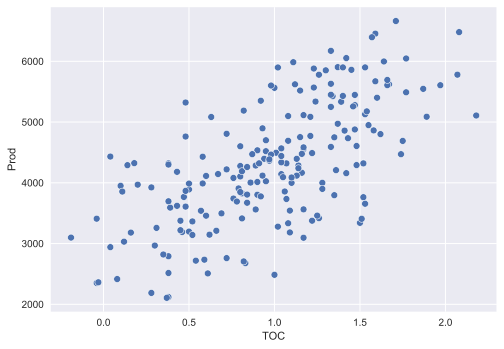

In [14]:
sns.scatterplot(x='TOC', y='Prod', data=data);

Из графика видно, что зависимость прямая и линейная.

2. Как бы вы объяснили полученный результат?

Наличие сильной мультиколлинеарности в данных, которая «портит» коэффициенты. 

***

### Задание 5.5

Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения, выше **0.7**. Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с объёмом добычи газа.

Также исключите из данных факторы, для которых корреляция с целевой переменной меньше **0.05**

1. Сильно коррелированные между собой факторы:
- **Perm** - **Por**
- **TOC** - **Por**

Оставляем **Por** (наибольший коэффициент корреляции с целевой переменной).    
Удаляем, соответственно, факторы **Perm**, **TOC**. Также удаляем фактор **Well**, т.к. корреляция с целевой переменной менее **0.05**

2. Постройте линейную регрессию на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте **матричную формулу NumPy**.

In [15]:
# обновляем исходный датасет
data.drop(['Perm', 'TOC', 'Well', 'Prod_predict'], axis=1, inplace=True)

In [16]:
# создаем матрицу наблюдений X и вектор правильных ответов y
X = np.array(data.drop(['Prod'], axis=1))
y = np.array(data[['Prod']])

# строим модель линейной регрессии
# создаём вектор из единиц
ones = np.ones(X.shape[0])
# добавляем вектор к таблице первым столбцом
X = np.column_stack([ones, X])
# вычисляем обратную матрицу Q
Q = np.linalg.inv(X.T @ X)
# вычисляем вектор коэффициентов
w = Q @ X.T @ y

In [17]:
#Выводим вычисленные значения коэффициентов в виде вектора
print('Vector w:\n {}'.format(np.around(w)))

Vector w:
 [[-1835.]
 [  293.]
 [ -200.]
 [   28.]
 [  517.]]


In [18]:
# составляем таблицу из признаков и их коэффициентов округленных до целого
w_df = pd.DataFrame({
    'Features': data.drop(['Prod'], axis=1).columns, 
    'Coefficients': np.round(w[1:,0])
})

# составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({
    'Features': ['INTERCEPT'], 
    'Coefficients': round(w[0,0])
})

# объединяем таблицы
coef_df = pd.concat([intercept_df, w_df], ignore_index=True)

display(coef_df)

,Features,Coefficients
0,INTERCEPT,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


3. Сделайте прогноз для всего обучающего набора данных и рассчитайте метрику **MAPE** (Mean Absolute Percentage Error). Результат приведите в процентах (не указывайте знак процента), округлив его до первого знака после точки-разделителя.

In [19]:
# задаем столбец с предсказанным таргетом
data['Prod_predict'] = 0

# перебираем строки датасета
for index, row in data.iterrows():
    # задаём параметры
    por_param = row['Por']
    ai_param = row['AI']
    brittle_param = row['Brittle'] 
    vr_param = row['VR']

    # делаем предсказание
    data.loc[index, 'Prod_predict'] = (
        w[0,0] + 
        w[1,0]*por_param + 
        w[2,0]*ai_param + 
        w[3,0]*brittle_param + 
        w[4,0]*vr_param
    )    

# задаем реальные значения таргета
y_real = data['Prod']
# задаем предсказанные значения таргета
y_predict = data['Prod_predict']

#Рассчитываем MAPE
print('MAPE score: {:.1f} %'.format(metrics.mean_absolute_percentage_error(y_real, y_predict) * 100))

MAPE score: 4.0 %


In [20]:
# сравним корреляцию факторов с таргетом и коэффициенты
display(coef_df)
display(data.corr()["Prod"])

,Features,Coefficients
0,INTERCEPT,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


Por             0.861910
AI             -0.390835
Brittle         0.237155
VR              0.323182
Prod            1.000000
Prod_predict    0.972214
Name: Prod, dtype: float64

4. Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

Да, знаки корреляций совпадают со знаками коэффициентов регрессии.

***
***

Мы хотим попробовать улучшить наш результат — метрику MAPE. Для этого воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку, поэтому для контроля качества модели мы будем использовать кросс-валидацию.

### Задание 8.1

Сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов PolynomialFeatures из библиотеки sklearn. Параметр include_bias установите в значение False.

1. Сколько факторов у вас получилось после генерации полиномиальных признаков?

In [21]:
# создаем матрицу наблюдений X и вектор правильных ответов y
X = data.drop(['Prod', 'Prod_predict'], axis=1)
y = data[['Prod']]

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# узнаем полученное количество факторов
X.shape[1]

34

2. Обучите модель линейной регрессии из библиотеки sklearn (LinearRegression) на полученных полиномиальных факторах.

Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.

In [22]:
# создаём модель линейной регрессии
lr = LinearRegression()
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(
    lr, 
    X, 
    y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)

print('MAPE на тренировочных фолдах: {:.1f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.1f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.8 %
MAPE на валидационных фолдах: 2.7 %


### Задание 8.2

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём L1-регуляризацию.

Обучите модель Lasso из библиотеки sklearn на полученных полиномиальных факторах, предварительно стандартизировав факторы с помощью StandardScaler. Коэффициент регуляризации выставите равным 5.

Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.

Чему равны средние значения метрики MAPE на тренировочных и валидационных фолдах? Ответ приведите в процентах (не указывайте знак процента), округлив его до первого знака после точки-разделителя.

In [23]:
# создаем матрицу наблюдений X и вектор правильных ответов y
X = data.drop(['Prod', 'Prod_predict'], axis=1)
y = data[['Prod']]

# проводим стандартизацию
scaler = StandardScaler()
X = scaler.fit_transform(X)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии
lr = Lasso(alpha=5)
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(
    lr, 
    X, 
    y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)

print('MAPE на тренировочных фолдах: {:.1f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.1f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.8 %
MAPE на валидационных фолдах: 2.3 %


### Задание 8.3

Проделаем то же самое с L2-регуляризацией.

Обучите модель Ridge из библиотеки sklearn на полученных полиномиальных факторах, предварительно стандартизировав факторы с помощью StandardScaler. Коэффициент регуляризации выставите равным 1.

Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.

Чему равны средние значения метрики MAPE на тренировочных и валидационных фолдах? Ответ приведите в процентах (не указывайте знак процента), округлив его до первого знака после точки-разделителя.

In [24]:
# создаем матрицу наблюдений X и вектор правильных ответов y
X = data.drop(['Prod', 'Prod_predict'], axis=1)
y = data[['Prod']]

# проводим стандартизацию
scaler = StandardScaler()
X = scaler.fit_transform(X)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии
lr = Ridge(alpha=1)
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(
    lr, 
    X, 
    y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)

print('MAPE на тренировочных фолдах: {:.1f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.1f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.8 %
MAPE на валидационных фолдах: 2.7 %
